<a href="https://colab.research.google.com/github/mohsin-tariq/gesture-recognition/blob/main/gesture-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime
import imageio.v2 as imageio
from PIL import Image
import matplotlib.pyplot as plt


We set the random seed so that the results don't vary drastically.

In [2]:
import os
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#defining variables to be used

train_doc = np.random.permutation(open('/content/drive/MyDrive/cnn_rnn/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/cnn_rnn/val.csv').readlines())
batch_size = 64
image_index = 2
# image dimensions
dim_x, dim_y = 120, 120
batches = range(6,28,2)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size, imgShow):
    print( 'Source path = ', source_path, '; batch size =', batch_size, 'showImage=', imgShow)
    img_idx = batches
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        t = np.random.permutation(folder_list)
        num_batches = 10
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                    #crop the images and resize them. Note that the images are of 2 different shape
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = Image.fromarray(image).resize((y, z))

                    if imgShow:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)
                    resized_image_array = np.array(resized_im)

                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = resized_image_array[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_image_array[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_image_array[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/cnn_rnn/train'
val_path = '/content/drive/MyDrive/cnn_rnn/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 2
print ('# epochs =', num_epochs)
print('# curr_dt_time=', curr_dt_time)

# training sequences = 663
# validation sequences = 100
# epochs = 2
# curr_dt_time= 2024-03-06 08:03:34.975181


Source path =  /content/drive/MyDrive/cnn_rnn/train ; batch size = 6 showImage= True


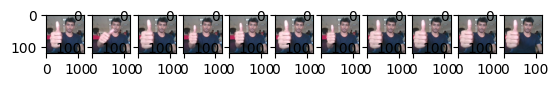

In [7]:
# testing generative
generatedData = generator(train_path, train_doc, 6, True)
d = next(generatedData)[0]


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
def modelSummary(model):
  optimiser = optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  print (model.summary())

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, ConvLSTM2D, GlobalAveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

# new_batch = range(5,50,2)
#input shape for the st layer
input_shape = (len(batches), dim_x, dim_y, 3)
np.random.seed(30)
#write your model here

In [10]:
# Model 1, Conv3d

model_1 = Sequential()
model_1.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model_1.add(MaxPooling3D(pool_size=2))

model_1.add(Conv3D(64, kernel_size=3, activation='relu'))
model_1.add(MaxPooling3D(pool_size=2))

model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(10, activation='softmax'))


modelSummary(model_1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 9, 118, 118, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3  (None, 4, 59, 59, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 28, 28, 64)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               1

In [11]:
# Model 2, Conv3d

model_2 = Sequential()

model_2.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model_2.add(Conv3D(64, kernel_size=3, activation='relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(64, kernel_size=3, activation='relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same'))

model_2.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling3D(pool_size=(3, 2, 2), strides=(2, 2, 2), padding='same'))
model_2.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(5, activation='softmax'))

modelSummary(model_2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 9, 118, 118, 32)   2624      
                                                                 
 conv3d_3 (Conv3D)           (None, 7, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 3, 58, 58, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 1, 56, 56, 64)     110656    
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 1, 56, 56, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 1, 56, 56, 256)   

In [ ]:
# Model 3, Conv3d

model_3 = Sequential()

model_3.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model_3.add(Conv3D(64, kernel_size=3, activation='relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Conv3D(128, kernel_size=3, activation='relu'))
model_3.add(MaxPooling3D(pool_size=(1, 2, 2)))

model_3.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model_3.add(MaxPooling3D(pool_size=(1, 2, 2)))

model_3.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model_3.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model_3.add(MaxPooling3D(pool_size=(1, 2, 2)))

model_3.add(Flatten())
model_3.add(Dense(512, activation='relu'))
model_3.add(Dense(5, activation='softmax'))


modelSummary(model_3)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 21, 118, 118, 32   2624      
                             )                                   
                                                                 
 conv3d_34 (Conv3D)          (None, 19, 116, 116, 64   55360     
                             )                                   
                                                                 
 max_pooling3d_23 (MaxPooli  (None, 9, 58, 58, 64)     0         
 ng3D)                                                           
                                                                 
 conv3d_35 (Conv3D)          (None, 7, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_24 (MaxPooli  (None, 7, 28, 28, 128)    0         
 ng3D)                                               

In [ ]:
# Model 4, Time Distributed, Conv2D, ConvLSTM2D and Batch Normalization
model_4 = Sequential()
model_4.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model_4.add(BatchNormalization())
model_4.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model_4.add(BatchNormalization())
model_4.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model_4.add(BatchNormalization())
model_4.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model_4.add(BatchNormalization())
model_4.add(GlobalAveragePooling2D())
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(5, activation='softmax'))


modelSummary(model_4)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeD  (None, 23, 118, 118, 8)   224       
 istributed)                                                     
                                                                 
 batch_normalization_32 (Ba  (None, 23, 118, 118, 8)   32        
 tchNormalization)                                               
                                                                 
 time_distributed_43 (TimeD  (None, 23, 116, 116, 16   1168      
 istributed)                 )                                   
                                                                 
 batch_normalization_33 (Ba  (None, 23, 116, 116, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 114, 114, 8)     

In [ ]:
# Model 5: Conv2D, GRU
model_5 = Sequential()
model_5.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model_5.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model_5.add(BatchNormalization())
model_5.add(Dropout(0.2))

model_5.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model_5.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model_5.add(BatchNormalization())
model_5.add(Dropout(0.2))

model_5.add(TimeDistributed(GlobalAveragePooling2D()))
model_5.add(TimeDistributed(Dense(64, activation='relu')))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.2))

model_5.add(GRU(128))
model_5.add(BatchNormalization())
model_5.add(Dense(5, activation='softmax'))


modelSummary(model_5)


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeD  (None, 23, 118, 118, 32   896       
 istributed)                 )                                   
                                                                 
 time_distributed_46 (TimeD  (None, 23, 59, 59, 32)    0         
 istributed)                                                     
                                                                 
 batch_normalization_36 (Ba  (None, 23, 59, 59, 32)    128       
 tchNormalization)                                               
                                                                 
 dropout_6 (Dropout)         (None, 23, 59, 59, 32)    0         
                                                                 
 time_distributed_47 (TimeD  (None, 23, 57, 57, 64)    18496     
 istributed)                                         

In [ ]:
# Model 6: Conv2D, GlobalAveragePooling3D, Dense and Batch Normalization
model_6 = Sequential()
model_6.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model_6.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model_6.add(BatchNormalization())

model_6.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model_6.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model_6.add(BatchNormalization())

model_6.add(TimeDistributed(
    Conv2D(128, (3,3), activation='relu'))
)
model_6.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model_6.add(BatchNormalization())

model_6.add(GlobalAveragePooling3D())
model_6.add(Dense(256, activation='relu'))
model_6.add(BatchNormalization())
model_6.add(Dense(5, activation='softmax'))


modelSummary(model_6)


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_51 (TimeD  (None, 23, 118, 118, 32   896       
 istributed)                 )                                   
                                                                 
 time_distributed_52 (TimeD  (None, 23, 59, 59, 32)    0         
 istributed)                                                     
                                                                 
 batch_normalization_40 (Ba  (None, 23, 59, 59, 32)    128       
 tchNormalization)                                               
                                                                 
 time_distributed_53 (TimeD  (None, 23, 57, 57, 64)    18496     
 istributed)                                                     
                                                                 
 time_distributed_54 (TimeD  (None, 23, 28, 28, 64)  

In [ ]:
# Time Distributed, Conv2D
model_7 = Sequential()
model_7.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model_7.add(TimeDistributed(MaxPooling2D((2,2))))
model_7.add(BatchNormalization())

model_7.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model_7.add(TimeDistributed(MaxPooling2D((2,2))))
model_7.add(BatchNormalization())

model_7.add(TimeDistributed(GlobalAveragePooling2D()))
model_7.add(TimeDistributed(Dense(64, activation='relu')))
model_7.add(BatchNormalization())

model_7.add(GRU(128))
model_7.add(BatchNormalization())
model_7.add(Dense(5, activation='softmax'))

modelSummary(model_7)


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_57 (TimeD  (None, 23, 118, 118, 32   896       
 istributed)                 )                                   
                                                                 
 time_distributed_58 (TimeD  (None, 23, 59, 59, 32)    0         
 istributed)                                                     
                                                                 
 batch_normalization_44 (Ba  (None, 23, 59, 59, 32)    128       
 tchNormalization)                                               
                                                                 
 time_distributed_59 (TimeD  (None, 23, 57, 57, 64)    18496     
 istributed)                                                     
                                                                 
 time_distributed_60 (TimeD  (None, 23, 28, 28, 64)  

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size, False)
val_generator = generator(val_path, val_doc, batch_size, False)
# d_2 = next(train_generator)[0]
print('train_generator = ', train_generator)
print('val_generator = ',val_generator)

train_generator =  <generator object generator at 0x7c0710e72b90>
val_generator =  <generator object generator at 0x7c0710e72c70>


In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
print(callbacks_list)

[<keras.src.callbacks.ModelCheckpoint object at 0x7c070ed74e80>, <keras.src.callbacks.ReduceLROnPlateau object at 0x7c070ed751e0>]


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
result = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-15-527cbe1f2039>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /content/drive/MyDrive/cnn_rnn/train ; batch size = 64 showImage= False
Epoch 1/2
 6/11 [===============>..............] - ETA: 16:35 - loss: 12762.9990 - categorical_accuracy: 0.1797

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(result.history['loss'])
# ax1 = plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(result.history['categorical_accuracy'])
ax2 = plt.plot(result.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')